#Equipo 21 - Identificación de firmas fraudulentas mediante un modelo de predicción
- Hinara Pastora Sanchez Mata
- Anna Ospina Bedoya
- Juan Jose Tobon

### Introducción a la inteligencia artificial 2024-01

## Contexto

Variables del problema

1. **Sector_score**: La puntuación general asignada a un sector en función de varios factores de riesgo.
2. **LOCATION_ID**: El identificador único para una ubicación o empresa específica.
3. **PARA_A**: Un parámetro de auditoría específico considerado en el análisis.
4. **Score_A**: La puntuación derivada de PARA_A, que indica el nivel de riesgo o desempeño.
5. **Risk_A**: El nivel de riesgo asociado con PARA_A.
6. **PARA_B**: Otro parámetro de auditoría evaluado durante el análisis.
7. **Score_B**: La puntuación derivada de PARA_B, que refleja el riesgo o desempeño asociado.
8. **Risk_B**: El nivel de riesgo relacionado con PARA_B.
9. **TOTAL**: El valor o puntuación acumulada considerando múltiples factores.
10. **numbers**: La cantidad de instancias u ocurrencias relevantes.
11. **Score_C**: La puntuación asociada a los números identificados.
12. **Risk_C**: El riesgo derivado de Score_C.
13. **Money_Value**: El valor financiero o activos que se están evaluando.
14. **Score_MV**: La puntuación asociada con Money_Value.
15. **Risk_D**: El nivel de riesgo asociado con la evaluación financiera (Money_Value).
16. **District_Loss**: La pérdida financiera o daño registrado en un distrito específico.
17. **PROB**: La probabilidad de ocurrencia del riesgo.
18. **Risk_E**: El riesgo evaluado en función de PROB.
19. **History**: Datos históricos o registros que impactan la evaluación actual.
20. **Prob**: La probabilidad general calculada del riesgo.
21. **Risk_F**: La evaluación del riesgo derivada de factores históricos y probabilísticos.
22. **Score**: La puntuación agregada considerando múltiples factores de riesgo.
23. **Inherent_Risk**: El nivel natural de riesgo presente sin aplicar ningún control.
24. **CONTROL_RISK**: El riesgo que permanece después de implementar los controles.
25. **Detection_Risk**: El riesgo de que los errores o fraudes no sean detectados.
26. **Audit_Risk**: El riesgo general asociado con el proceso de auditoría.
27. **Risk**: Una medida general o resumen del riesgo.

### Importar librerias

In [63]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from collections import Counter

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

### Librerías Árboles de Decisión

In [96]:
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as PImage
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

### Librerías Gaussian Naive Bayes

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

## Lectura de datos

Cargar datos

In [37]:
dataframe = pd.read_csv('audit_risk.csv')

Mezclar datos

In [38]:
dataframe = dataframe.sample(frac=1).reset_index(drop=True)

Eliminamos la variable `Detection_Risk ` debido a que sus valores son estaticos y no se correlacionan con la variable objetivo



In [39]:
dataframe = dataframe.drop(['Detection_Risk'], axis=1)
dataframe.shape


(776, 26)

Se hace el conteo de datos nulos para tenerlos en cuenta en su manejo en el preprocesamiento

In [41]:
dataframe.isna().sum()

,0
Sector_score,0
LOCATION_ID,0
PARA_A,0
Score_A,0
Risk_A,0
PARA_B,0
Score_B,0
Risk_B,0
TOTAL,0
numbers,0


Eliminamos el valor nulo de `Money_Value`

In [42]:
dataframe = dataframe.dropna(subset=['Money_Value'])

Seleccionamos las características (X) y la variable objetivo (y), en este caso queremos predecir el riesgo 'Risk'

In [43]:
X = dataframe.drop(['Risk'], axis=1)
y = dataframe['Risk']

display(X, y)

,Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,...,District_Loss,PROB,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Audit_Risk
0,2.72,6,1.51,0.4,0.604,0.00,0.2,0.000,1.51,5.0,...,2,0.2,0.4,0,0.2,0.0,2.2,2.004,0.4,0.4008
1,55.57,8,1.05,0.4,0.420,2.17,0.6,1.302,3.22,5.0,...,4,0.2,0.8,0,0.2,0.0,3.6,3.522,0.8,1.4088
2,1.99,19,1.62,0.4,0.648,0.00,0.2,0.000,1.62,5.0,...,6,0.2,1.2,0,0.2,0.0,2.6,2.848,1.2,1.7088
3,55.57,21,0.09,0.2,0.018,0.00,0.2,0.000,0.09,5.0,...,2,0.2,0.4,0,0.2,0.0,2.0,1.418,0.4,0.2836
4,1.99,6,0.90,0.2,0.180,0.00,0.2,0.000,0.90,5.0,...,2,0.2,0.4,0,0.2,0.0,2.0,1.970,0.4,0.3940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,1.99,5,0.29,0.2,0.058,0.00,0.2,0.000,0.29,5.0,...,2,0.2,0.4,0,0.2,0.0,2.0,1.470,0.4,0.2940
772,2.37,18,3.43,0.6,2.058,1.00,0.4,0.400,4.43,5.5,...,2,0.4,0.8,1,0.4,0.4,4.2,35.444,1.2,21.2664
773,55.57,6,0.38,0.2,0.076,0.49,0.2,0.098,0.87,5.0,...,2,0.2,0.4,0,0.2,0.0,2.0,1.574,0.4,0.3148
774,3.41,22,2.70,0.6,1.620,45.16,0.6,27.096,47.86,5.0,...,2,0.2,0.4,0,0.2,0.0,4.0,52.790,0.4,10.5580


,Risk
0,0
1,1
2,1
3,0
4,0
...,...
771,0
772,1
773,0
774,1


#### Información del dataset

In [44]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 775 entries, 0 to 775
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sector_score   775 non-null    float64
 1   LOCATION_ID    775 non-null    object 
 2   PARA_A         775 non-null    float64
 3   Score_A        775 non-null    float64
 4   Risk_A         775 non-null    float64
 5   PARA_B         775 non-null    float64
 6   Score_B        775 non-null    float64
 7   Risk_B         775 non-null    float64
 8   TOTAL          775 non-null    float64
 9   numbers        775 non-null    float64
 10  Score_B.1      775 non-null    float64
 11  Risk_C         775 non-null    float64
 12  Money_Value    775 non-null    float64
 13  Score_MV       775 non-null    float64
 14  Risk_D         775 non-null    float64
 15  District_Loss  775 non-null    int64  
 16  PROB           775 non-null    float64
 17  RiSk_E         775 non-null    float64
 18  History        

#### Revisión de filas duplicadas

Revisión de filas

In [45]:
X.duplicated().any()

True

Como hay filas duplicadas las eliminamos

In [46]:
X = X.drop_duplicates()
X.duplicated().any()

False

## Exploracion de datos

#### Estadísticas descriptivas

In [47]:
X.describe()

,Sector_score,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,Score_B.1,...,District_Loss,PROB,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Audit_Risk
count,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,...,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000
mean,19.674265,2.494266,0.354068,1.375662,10.997888,0.315223,6.450276,13.459871,5.068898,0.224147,...,2.509186,0.206299,0.520210,0.106299,0.217060,0.054593,2.714961,17.978387,0.574803,7.293289
std,24.113212,5.721426,0.174424,3.467094,50.520704,0.170658,30.335843,51.751430,0.266709,0.081023,...,1.231665,0.037842,0.291511,0.535703,0.068571,0.308549,0.861751,55.196904,0.447502,39.010399
min,1.850000,0.000000,0.200000,0.000000,0.000000,0.200000,0.000000,0.000000,5.000000,0.200000,...,2.000000,0.200000,0.400000,0.000000,0.200000,0.000000,2.000000,1.400000,0.400000,0.280000
25%,2.370000,0.260000,0.200000,0.052000,0.000000,0.200000,0.000000,0.590000,5.000000,0.200000,...,2.000000,0.200000,0.400000,0.000000,0.200000,0.000000,2.000000,1.594000,0.400000,0.318800
50%,3.890000,0.905000,0.200000,0.181000,0.445000,0.200000,0.089000,1.425000,5.000000,0.200000,...,2.000000,0.200000,0.400000,0.000000,0.200000,0.000000,2.400000,2.239000,0.400000,0.600000
75%,55.570000,2.517500,0.600000,1.510500,4.422500,0.400000,2.108000,8.025000,5.000000,0.200000,...,2.000000,0.200000,0.400000,0.000000,0.200000,0.000000,3.400000,11.005000,0.400000,3.458600
max,59.850000,85.000000,0.600000,51.000000,1264.630000,0.600000,758.778000,1268.910000,9.000000,0.600000,...,6.000000,0.600000,2.400000,9.000000,0.600000,5.400000,5.200000,801.262000,5.800000,961.514400


Elaboramos un histograma por cada variable

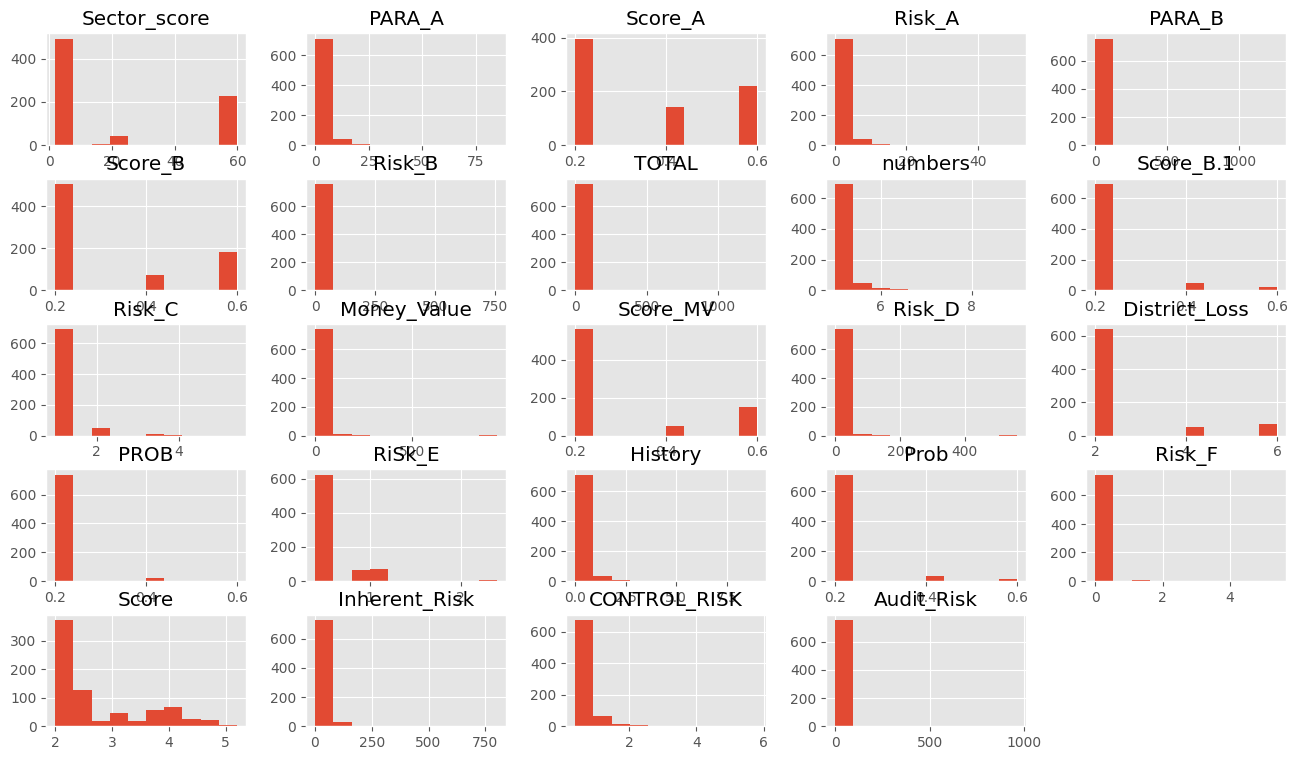

In [48]:
X.hist()
plt.show()

### Variable objetivo vs Datos involucrados

Visualizamos la distribución de las columnas categóricas en relación con la variable objetivo Risk

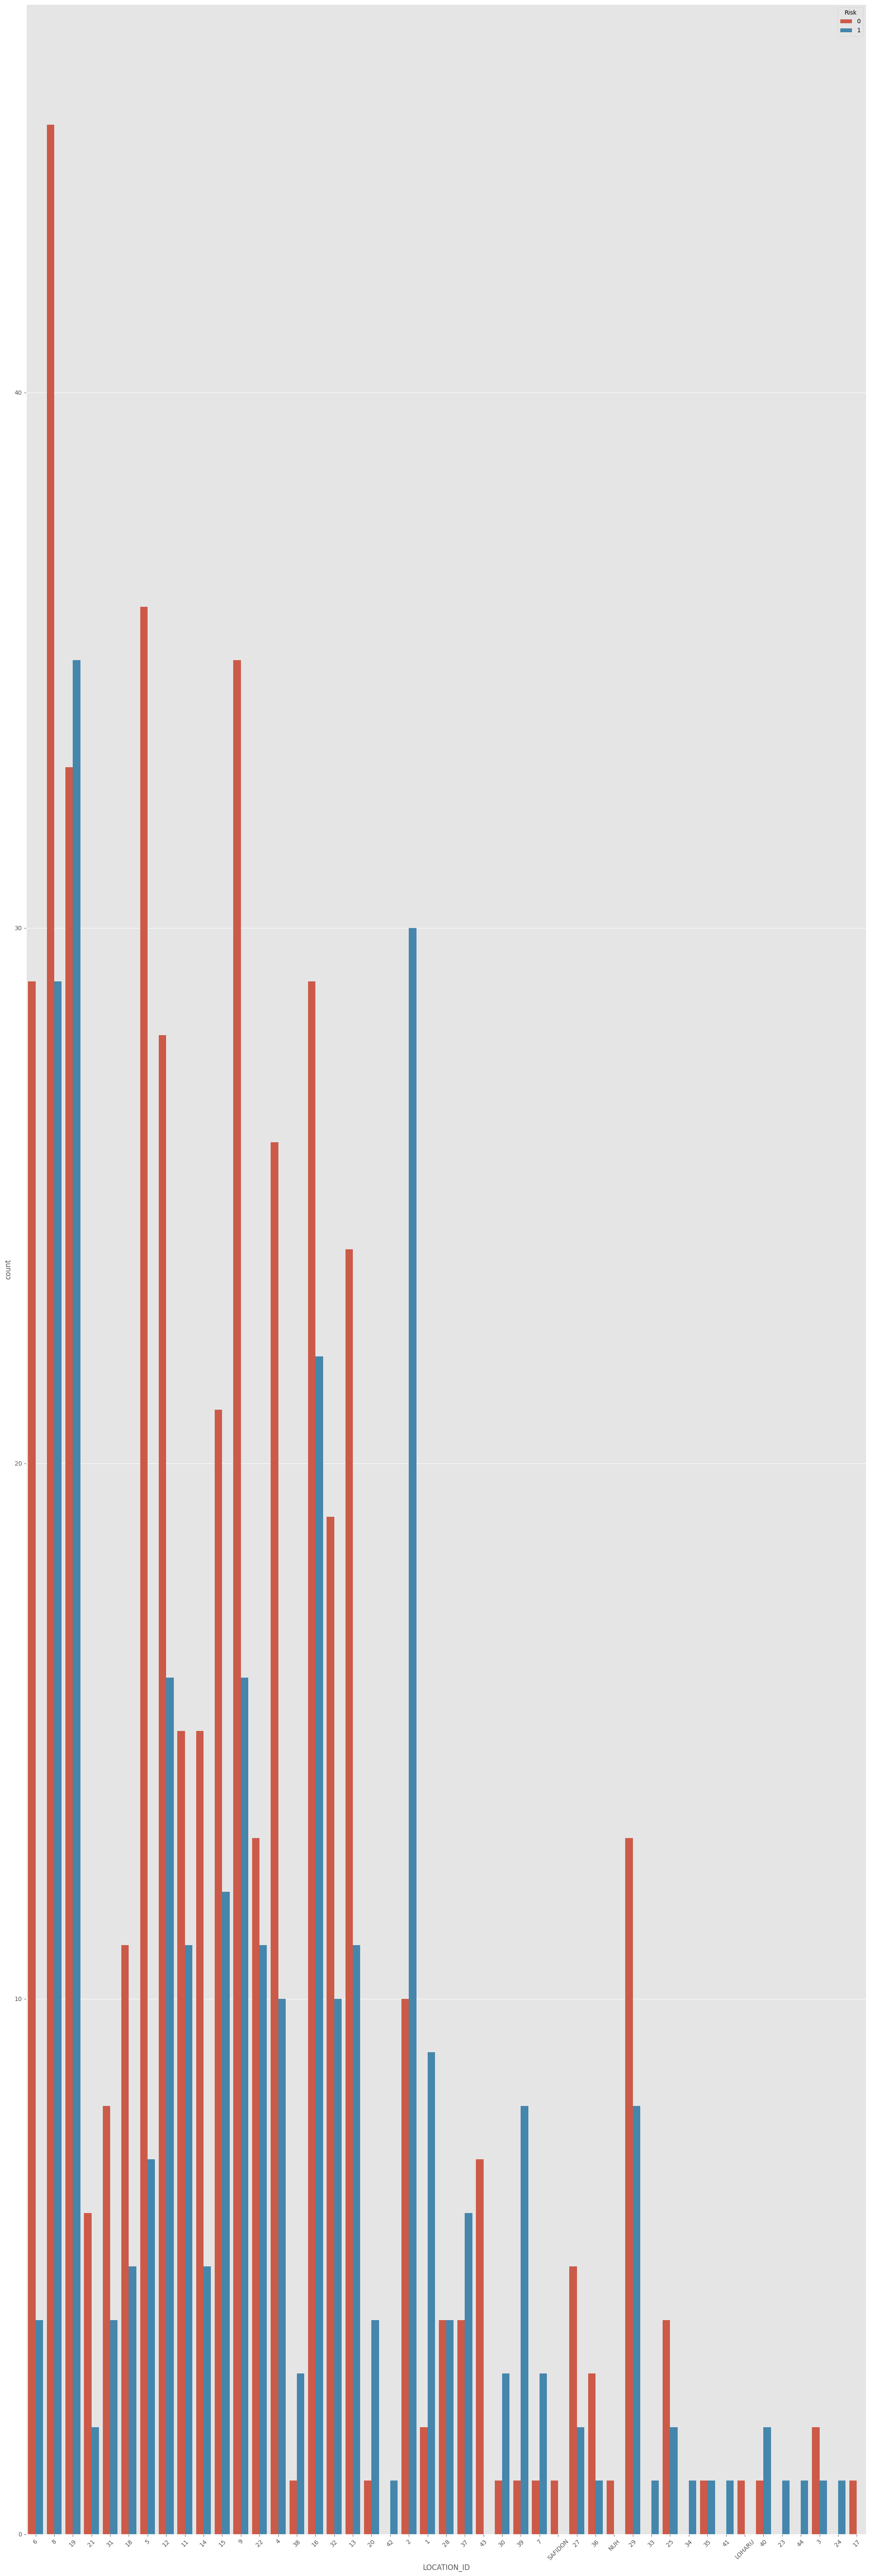

In [49]:
# Listamos las columnas categóricas
cat_cols = X.select_dtypes(include=['object']).columns.to_list()

# Concatenamos X e y para análisis
X_y = pd.concat([X, y], axis=1)

# Calculamos el número de filas y columnas necesarias
num_plots = len(cat_cols)
num_cols = 2  # Definimos 3 columnas para que los gráficos se ajusten bien
num_rows = (num_plots + num_cols - 1) // num_cols  # Esto asegura que se ajuste el número de filas

# Creamos subplots
_, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))

# Aplanamos la matriz de ejes para facilitar la indexación
ax = ax.flatten()

# Generamos los gráficos
for i, col in enumerate(cat_cols):
    sns.countplot(data=X_y, x=col, ax=ax[i], hue='Risk')
    ax[i].tick_params(axis='x', rotation=45)  # Rotar las etiquetas del eje X

# Eliminamos cualquier subplot vacío si los hay
for j in range(i + 1, len(ax)):
    ax[j].remove()

plt.tight_layout()
plt.show()

### Variable objetivo

**Seleccionamos los datos de entrenamiento y prueba:** Risk

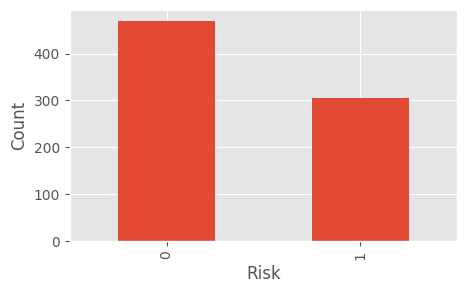

In [50]:
y.value_counts().plot.bar(figsize=(5, 3))

plt.xlabel("Risk")
plt.ylabel("Count")
plt.show()

## Preparacion para la clasificación

#### Encoding de las variables que lo necesiten
Usamos `ColumnEncoder` de `Sklearn.compose`

Esta clase nos permite hacer el transformaciones a varias columnas de una sola vez, a demas de poder hacer las mismas transformaciones a valores futuros

Esta clase recibe una lista de tuplas con la estructura: **(nombre transformacion, Transformer, lista de columnas a transformar)**

In [52]:
# Combinamos X e y para asegurarnos de que las mismas filas se eliminen en ambos
X_y_combined = pd.concat([X, y], axis=1)

# Eliminamos las filas con NaN en cualquier columna
X_y_combined_clean = X_y_combined.dropna()

# Separamos X e y nuevamente
X_clean = X_y_combined_clean.drop(columns=y.name)
y_clean = X_y_combined_clean[y.name]

# Verificamos que se eliminaron correctamente
print(X_clean.info())
print(y_clean.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 762 entries, 0 to 775
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sector_score   762 non-null    float64
 1   LOCATION_ID    762 non-null    object 
 2   PARA_A         762 non-null    float64
 3   Score_A        762 non-null    float64
 4   Risk_A         762 non-null    float64
 5   PARA_B         762 non-null    float64
 6   Score_B        762 non-null    float64
 7   Risk_B         762 non-null    float64
 8   TOTAL          762 non-null    float64
 9   numbers        762 non-null    float64
 10  Score_B.1      762 non-null    float64
 11  Risk_C         762 non-null    float64
 12  Money_Value    762 non-null    float64
 13  Score_MV       762 non-null    float64
 14  Risk_D         762 non-null    float64
 15  District_Loss  762 non-null    float64
 16  PROB           762 non-null    float64
 17  RiSk_E         762 non-null    float64
 18  History        

Este código utiliza `ColumnTransformer` de la biblioteca `scikit-learn` para transformar un conjunto de datos `X_clean`. Codifica la columna categórica `LOCATION_ID` en valores ordinales y deja las demás columnas sin cambios

In [53]:
categorical_cols = ["LOCATION_ID"]

ColTransformer = ColumnTransformer(
    transformers = [
            ("cat_data_encoding", OrdinalEncoder(), categorical_cols),
            ("other_data", "passthrough", X_clean.columns.difference(categorical_cols))
    ],
    verbose_feature_names_out = False
)

X_encoded = ColTransformer.fit_transform(X_clean)

X_encoded

array([[38.    ,  0.4008,  0.4   , ...,  2.72  ,  1.51  ,  5.    ],
       [40.    ,  1.4088,  0.8   , ..., 55.57  ,  3.22  ,  5.    ],
       [ 9.    ,  1.7088,  1.2   , ...,  1.99  ,  1.62  ,  5.    ],
       ...,
       [38.    ,  0.3148,  0.4   , ..., 55.57  ,  0.87  ,  5.    ],
       [13.    , 10.558 ,  0.4   , ...,  3.41  , 47.86  ,  5.    ],
       [12.    ,  0.3656,  0.4   , ..., 55.57  ,  1.07  ,  5.    ]])

### Selección de características para la clasificación

#### Matriz de correlaciones para variables categoricas


Este código define una función `cramers_V` que calcula la medida de asociación de Cramér (Cramér’s V) para todas las combinaciones de columnas en un DataFrame `df`

In [54]:
def cramers_V(df):
    def get_cramersV_corr(var1, var2):
        from scipy.stats import chi2_contingency
        crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))
        stat = chi2_contingency(crosstab)[0]
        obs = np.sum(crosstab)
        mini = min(crosstab.shape) - 1
        return (stat/(obs*mini))

    rows= []
    for var1 in df.columns:
        col = []
        for var2 in df.columns:
            cramers = get_cramersV_corr(df[var1], df[var2])
            col.append(round(cramers,2))
        rows.append(col)

    return pd.DataFrame(rows, columns=df.columns, index=df.columns)

Este código crea un mapa de calor para visualizar la medida de asociación de Cramér (Cramér’s V) entre las columnas categóricas `LOCATION_ID` y `Risk` en el DataFrame `X_y`.

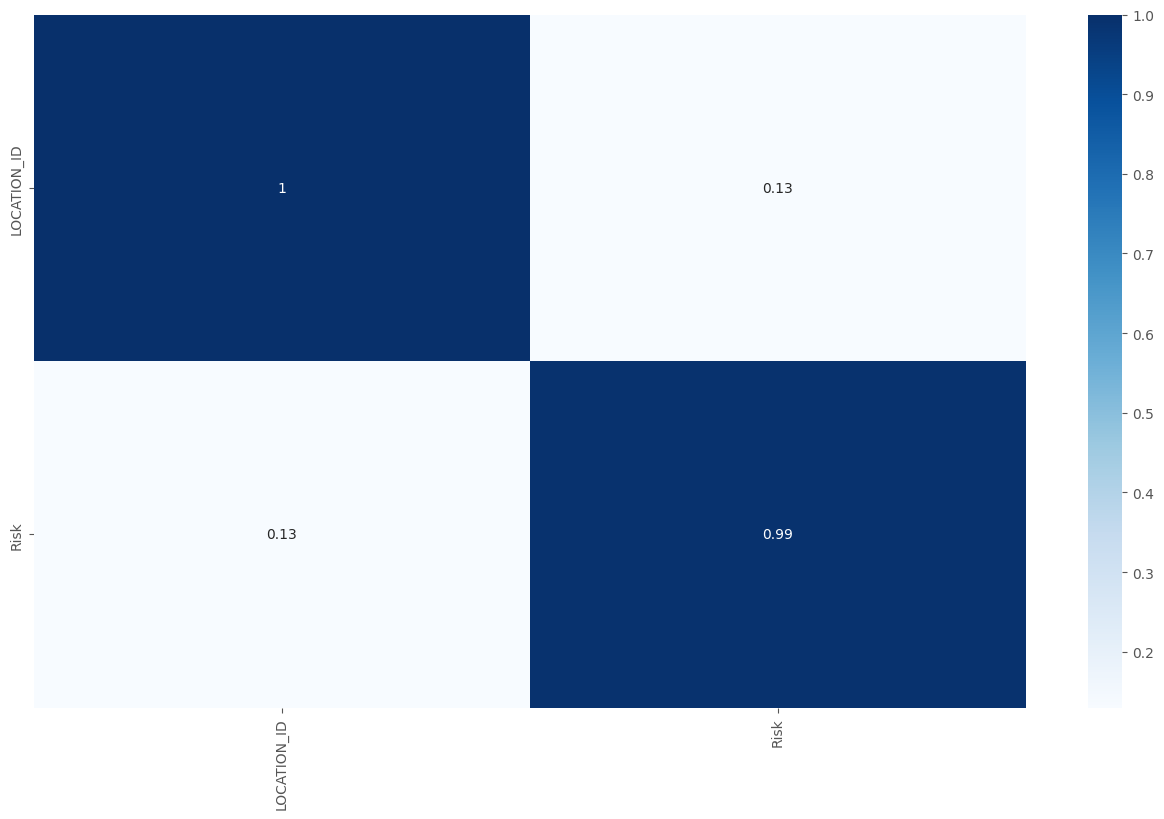

In [55]:
categorical_cols = [ "LOCATION_ID","Risk"]
sns.heatmap( cramers_V(X_y[categorical_cols]) , annot=True, cmap="Blues")

plt.xticks(rotation=90)
plt.show()

El resultado del mapa de calor que muestra la medida de asociación de Cramér (Cramér's V) entre las columnas categóricas `LOCATION_ID` y `Risk` en el DataFrame demuestra:

1. **Diagonal principal (1.00)**:
   - Los valores en la diagonal principal son 1.00, lo cual es esperado porque cada variable está perfectamente correlacionada consigo misma.

2. **Valores fuera de la diagonal**:
   - **0.13**: Indica una correlación débil entre `Risk` y `LOCATION_ID`.

#### Matriz de correlaciones para variables numericas

Para establecer una correlacion **lineal** entre las variables numericas usaremos la correlacion de Pearson, este valor se mueve entre `[-1, 1]`, siendo valores cercanos a 1 o -1 que las dos variables estan correlacionadas y valores cercanos a 0 que no lo estan

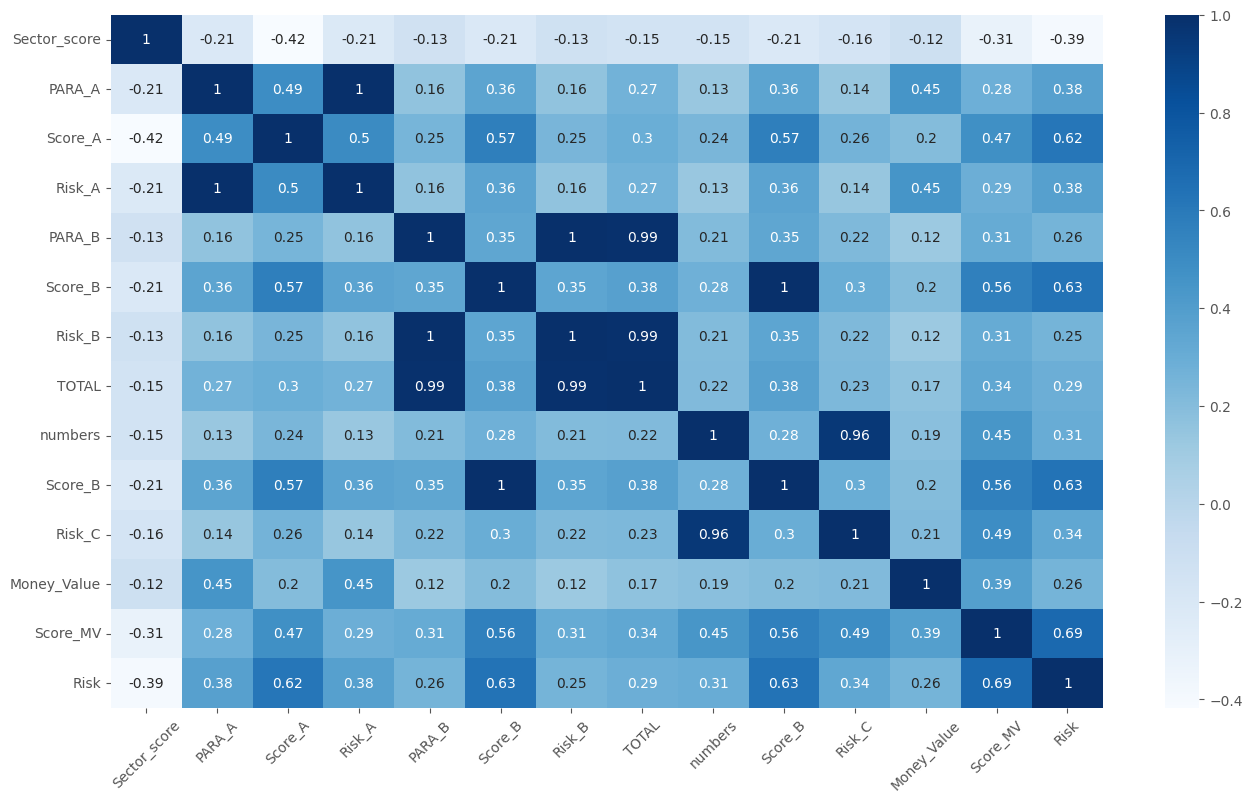

In [56]:
numerical_cols = [ "Sector_score", "PARA_A", "Score_A", "Risk_A", "PARA_B", "Score_B", "Risk_B", "TOTAL", "numbers", "Score_B", "Risk_C", "Money_Value", "Score_MV", "Risk"]

sns.heatmap( X_y[numerical_cols].corr() , annot=True, cmap="Blues")
plt.xticks(rotation=45)
plt.show()

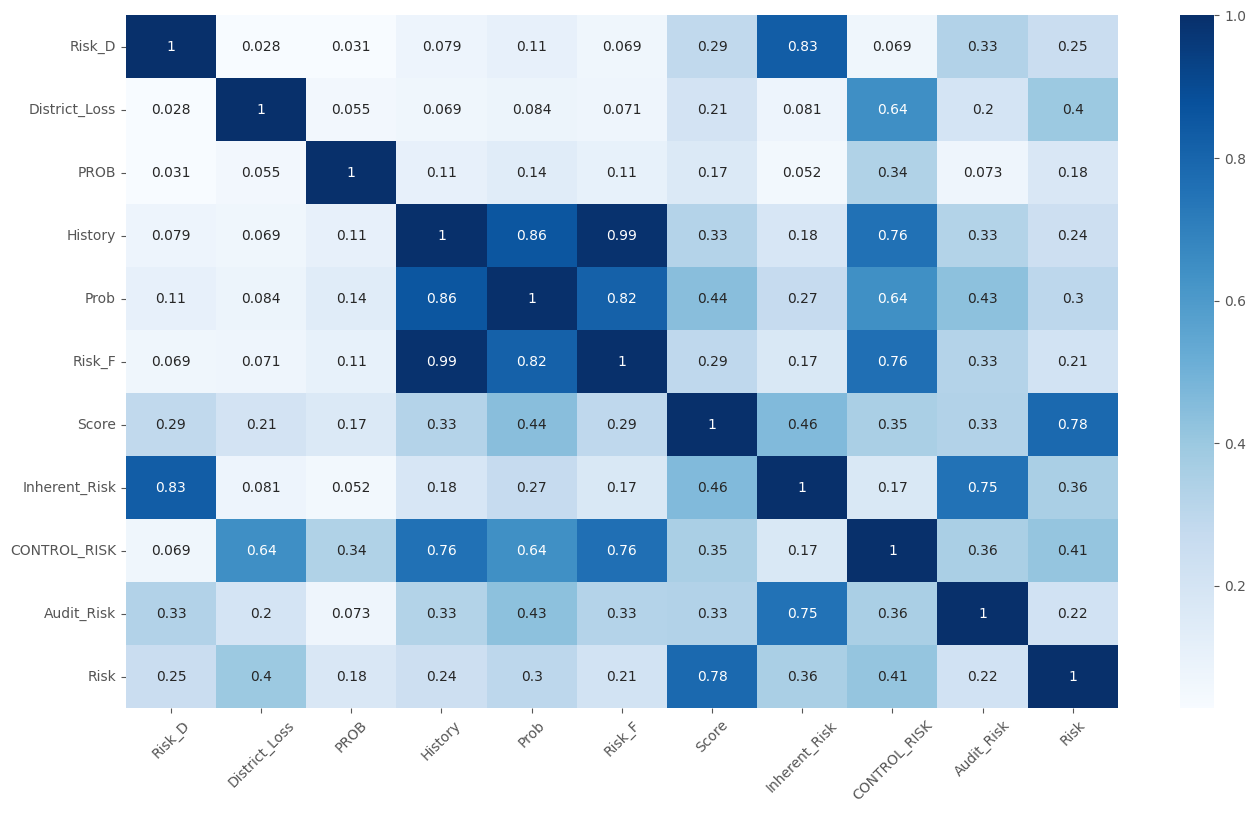

In [57]:
numerical_cols = [ "Risk_D", "District_Loss", "PROB", "History", "Prob", "Risk_F", "Score", "Inherent_Risk", "CONTROL_RISK", "Audit_Risk", "Risk"]

sns.heatmap( X_y[numerical_cols].corr() , annot=True, cmap="Blues")
plt.xticks(rotation=45)
plt.show()

#### SelectKBest

Seleccionamos las K caracteristicas que tienen más peso en la clasificación (basado en una funcion de scoring, por defecto `f_classif`)

In [58]:
kbest = SelectKBest(k="all").fit(X_encoded, y_clean)

pd.Series(data=kbest.scores_, index=ColTransformer.get_feature_names_out()).sort_values(ascending=False)

,0
Score,1220.310800
Score_MV,683.050800
Score_B,511.922677
Score_A,468.401442
CONTROL_RISK,155.976034
RiSk_E,151.004325
District_Loss,143.817876
Sector_score,136.701370
Risk_A,130.957394
PARA_A,125.710400


Seleccionamos las 4 mejores caracteristicas y filtramos el dataset. Estas variables serán posteriormente utilizadas para la clasificación

In [61]:
# Seleccionamos las 4 mejores características
kbest = SelectKBest(k=4).fit(X_encoded, y_clean)

# Obtenemos los nombres de las columnas seleccionadas
selected_features = kbest.get_support(indices=True)
selected_feature_names = ColTransformer.get_feature_names_out()[selected_features]

# Filtramos el DataFrame original para conservar solo las columnas seleccionadas
X_selected_df = pd.DataFrame(X_encoded[:, selected_features], columns=selected_feature_names)

# Mostramos el nuevo DataFrame
print(X_selected_df)

# Obtenemos las puntuaciones de las características seleccionadas
selected_scores = kbest.scores_[selected_features]

# Creamos una Serie con los nombres de las columnas seleccionadas y sus puntuaciones, ordenada de mayor a menor
selected_series = pd.Series(data=selected_scores, index=selected_feature_names).sort_values(ascending=False)

# Mostramos las 4 mejores características con sus puntuaciones
print(selected_series)


     Score  Score_A  Score_B  Score_MV
0      2.2      0.4      0.2       0.2
1      3.6      0.4      0.6       0.2
2      2.6      0.4      0.2       0.2
3      2.0      0.2      0.2       0.2
4      2.0      0.2      0.2       0.2
..     ...      ...      ...       ...
757    2.0      0.2      0.2       0.2
758    4.2      0.6      0.4       0.6
759    2.0      0.2      0.2       0.2
760    4.0      0.6      0.6       0.6
761    2.2      0.4      0.2       0.2

[762 rows x 4 columns]
Score       1220.310800
Score_MV     683.050800
Score_B      511.922677
Score_A      468.401442
dtype: float64


Utilizamos **SelectKBest** para seleccionar las 4 mejores características del conjunto de datos `X_encoded` en función de su relación con la variable objetivo `y_clean`. Donde obtenemos como resultado que:
   - El DataFrame `X_selected_df` muestra las 4 mejores características seleccionadas para cada una de las 762 filas del conjunto de datos original.
   - La Serie `selected_series` muestra las puntuaciones de las 4 mejores características:
     - **Score**: 1220.310800
     - **Score_MV**: 683.050800
     - **Score_B**: 511.922677
     - **Score_A**: 468.401442

Estas puntuaciones indican la importancia relativa de cada característica en relación con la variable objetivo. Las características con puntuaciones más altas tienen una mayor influencia en la predicción de la variable objetivo.



---



Convertimos el DataFrame a un numpy.ndarray

In [62]:
X_selected_array = X_selected_df.to_numpy()

print(type(X_selected_array))

<class 'numpy.ndarray'>


#### Separar los datos en entrenamiento y prueba

Para esto usaremos `train_test_split` de la libreria `sklearn.model_selection`, dependiendo de la cantidad de datos que se tengan puede ser recomendable usar más o menos datos para el entrenamiento

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_selected_array, y_clean, train_size=.75)

Probamos con diferentes valores (0.70, 0.75 y 0.80) donde obtuvimos como resultados:


*   0.60 = 0.94 de accurancy
*   0.75 = 0.95 de accurancy
*   0.80 = 0.94 de accurancy

Por lo que observamos que el mejor es ```0.75``` para el parametro de  ```train_size```





---
Contamos la cantidad de muestras de cada clase y el peso de las mismas como el inverso de su frecuencia relativa y cambiamos el parametro del `cls` antes de seguir con los procedimientos


In [69]:
class_counts = Counter(y_train)

class_weight_dict = {cls: 346/count for cls, count in class_counts.items()}
print(class_counts)
print(class_weight_dict)

Counter({0: 346, 1: 225})
{0: 1.0, 1: 1.5377777777777777}


#### Evaluación de parametros del modelo

Usaremos `GridSearchCV` de la libreria `sklearn.model_selection` para evaluar los parametros del modelo

Tenemos varios hiperparámetros, estos son:

* Criterio

* Profundidad Máxima

* Mínimo número para hacer el split

* Mínimo número de samples por cada hoja


El primer parámetro que tenemos es el criterio para decidir cómo hacer el split (gini o entropía)

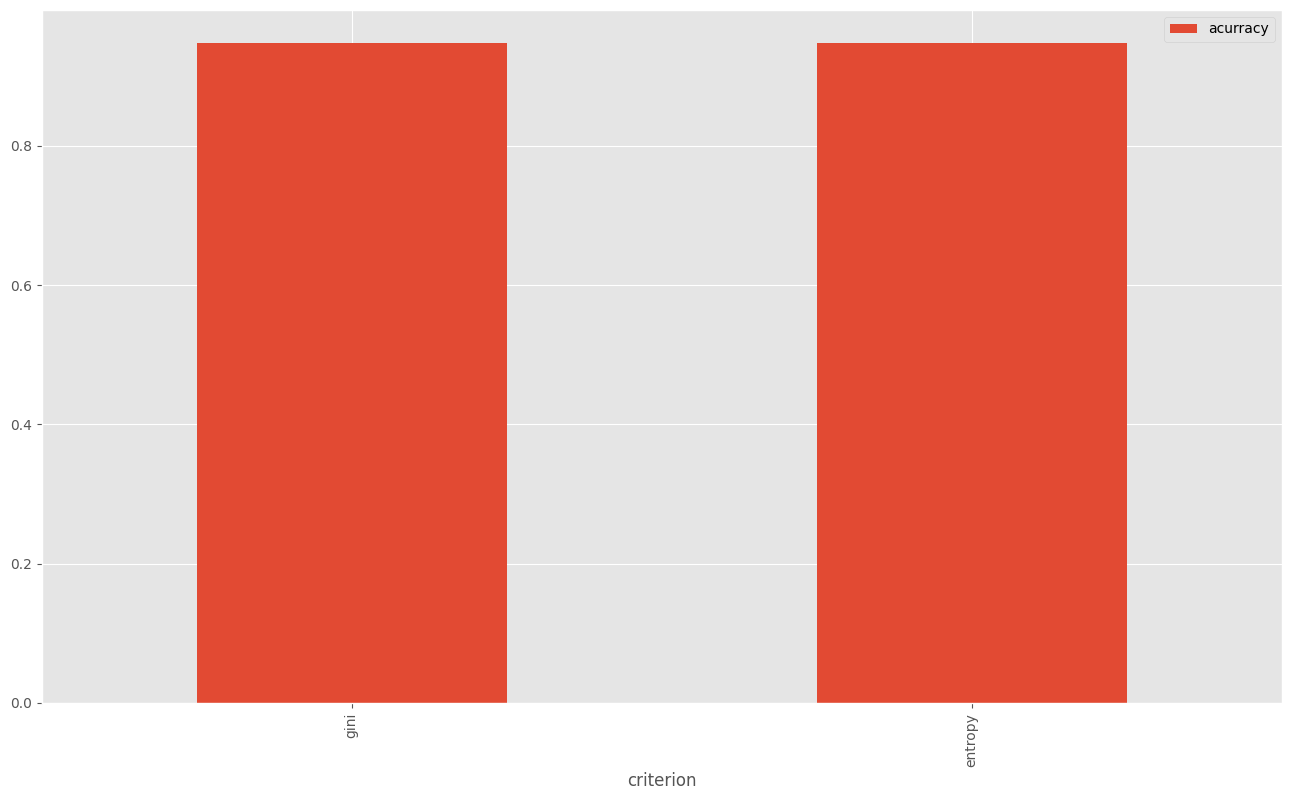

In [70]:
grid = {"criterion": ["gini", "entropy"]}

criterion_model = GridSearchCV(
    estimator = DecisionTreeClassifier(class_weight=class_weight_dict),
    param_grid = grid
)
criterion_model.fit(X_train, y_train)


df_results = pd.DataFrame(criterion_model.cv_results_["params"])
df_results["acurracy"] = criterion_model.cv_results_["mean_test_score"]

df_results.plot.bar(x="criterion", y="acurracy")

plt.show()

No hay una diferencia significativa en la precisión del modelo al usar `gini` o `entropy `como criterio de división. Esto indica que ambos criterios son igualmente efectivos para este conjunto de datos y modelo específico.

### Altura del arbol

Vemos que profundidad de árbol es optima

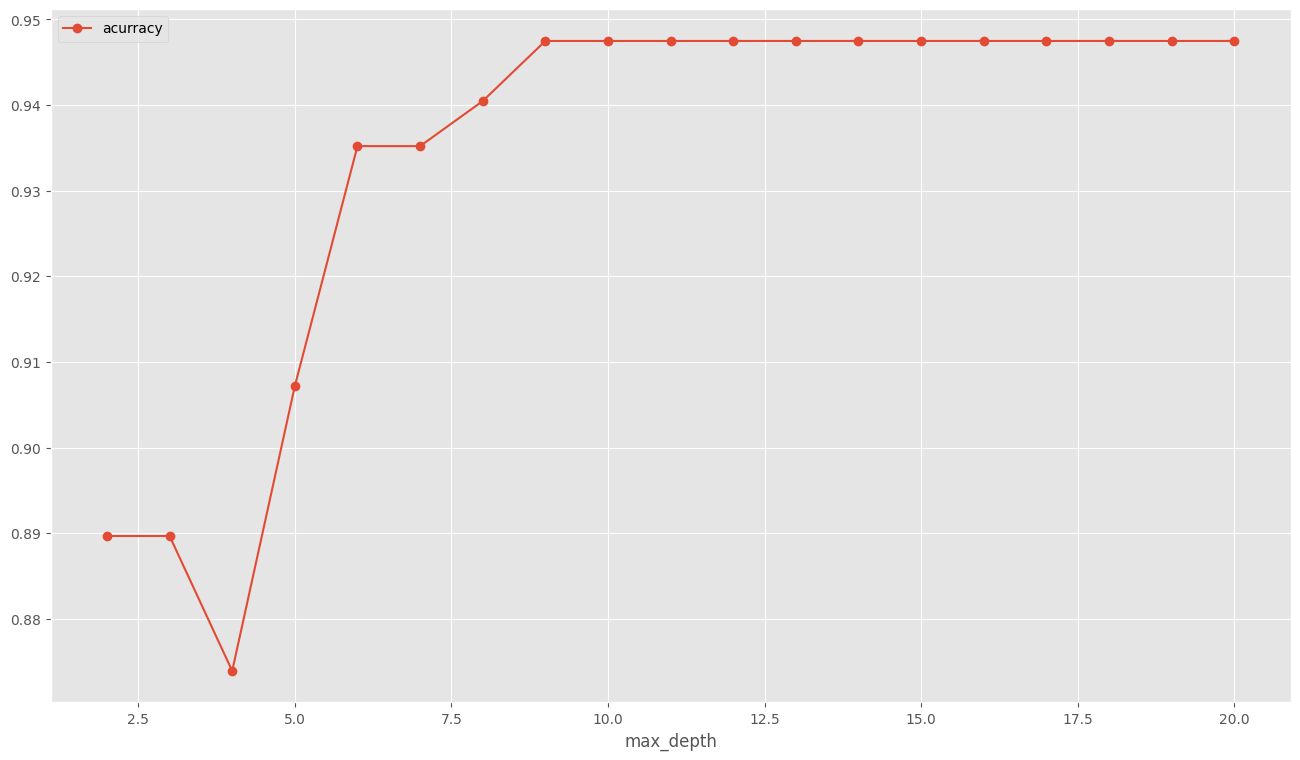

In [71]:
grid = {"max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}
max_depth_model = GridSearchCV(
    estimator = DecisionTreeClassifier(class_weight=class_weight_dict),
    param_grid = grid
)
max_depth_model.fit(X_train, y_train)


df_results = pd.DataFrame(max_depth_model.cv_results_["params"])
df_results["acurracy"] = max_depth_model.cv_results_["mean_test_score"]

df_results.plot.line(x="max_depth", y="acurracy", marker="o")

plt.show()

Aumentar la profundidad del árbol de decisión mejora la precisión del modelo hasta un cierto punto (alrededor de max_depth de 6). Más allá de una profundidad de 6, la precisión se estabiliza, lo que sugiere que profundidades mayores no aportan beneficios adicionales significativos en términos de precisión. Y la elección de un max_depth de 6 parece ser un buen punto de equilibrio, ya que proporciona una alta precisión sin el riesgo de sobreajuste que podría ocurrir con profundidades mayores.



---

Vemos el mínimo número de samples para poder hacer un split

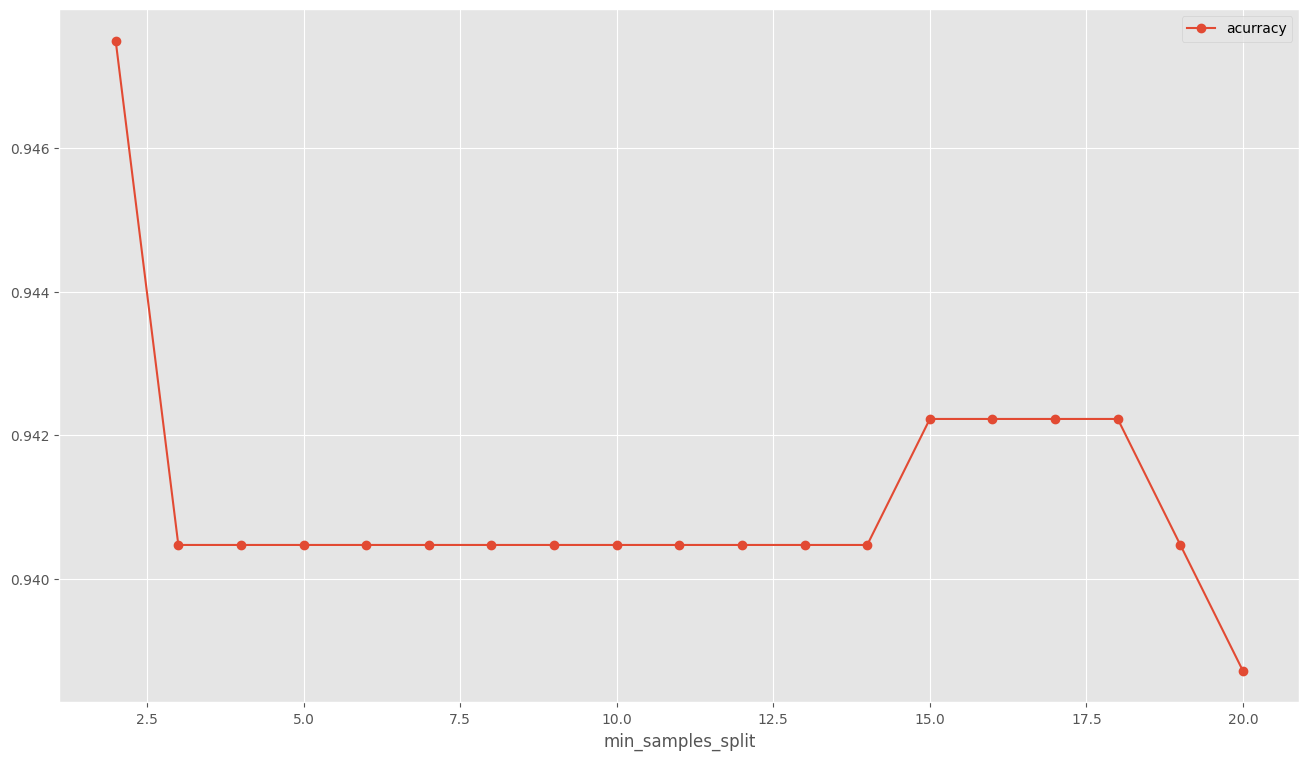

In [72]:
#  evaluar min_samples_split
grid = {"min_samples_split": range(2, 20 + 1)}
min_samples_split_model = GridSearchCV(
    estimator = DecisionTreeClassifier(class_weight=class_weight_dict),
    param_grid = grid
)
min_samples_split_model.fit(X_train, y_train)


df_results = pd.DataFrame(min_samples_split_model.cv_results_["params"])
df_results["acurracy"] = min_samples_split_model.cv_results_["mean_test_score"]

df_results.plot.line(x="min_samples_split", y="acurracy", marker="o")

plt.show()

* **Mejora Inicial:** La precisión es más alta con un min_samples_split de 2, lo que sugiere que dividir nodos con pocas muestras inicialmente mejora la precisión.
* **Estabilización:** La precisión se mantiene relativamente estable con ligeras variaciones entre min_samples_split de 3 a 15.
* **Caída Final:** Después de un min_samples_split de 17, la precisión disminuye, indicando que dividir nodos con demasiadas muestras puede reducir la capacidad del modelo para capturar patrones importantes.


---

Veamos cuantos samples deberia tener como minimo un nodo hoja

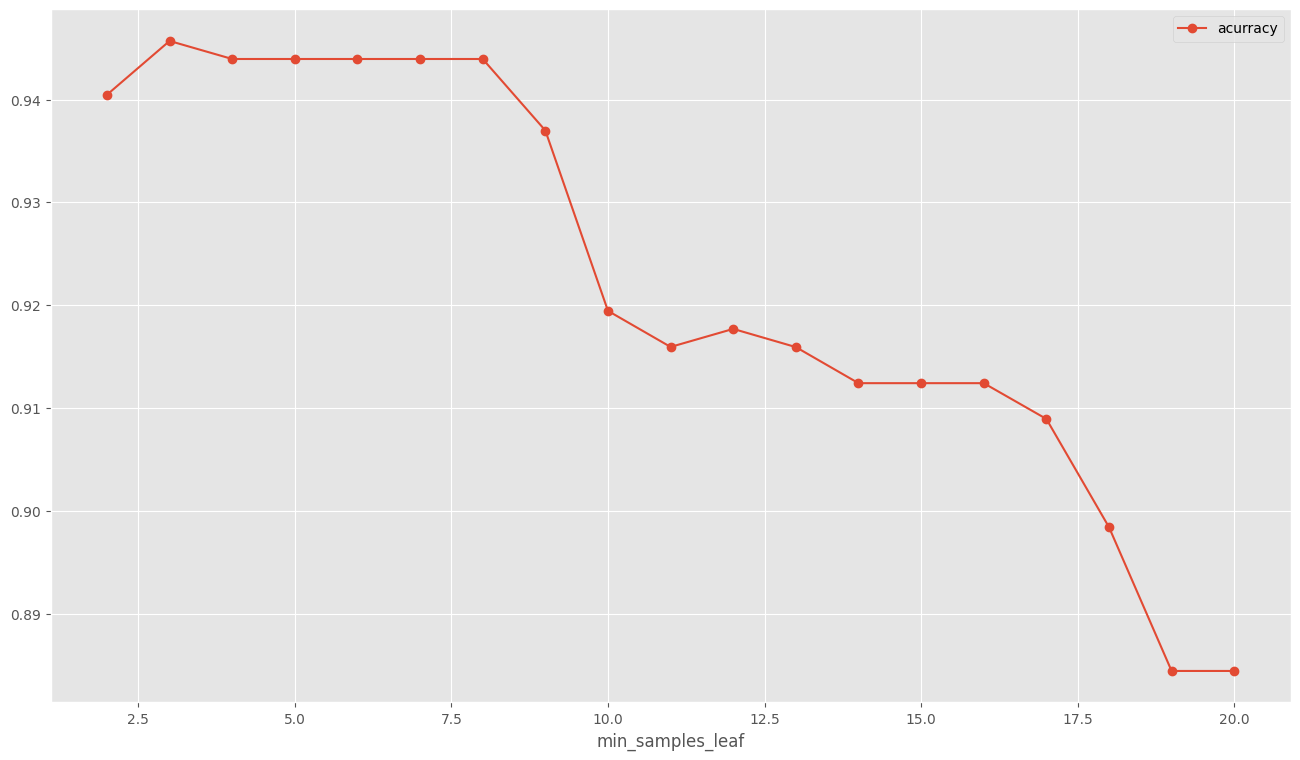

In [73]:
# evaluar min_samples_leaf
grid = {"min_samples_leaf": range(2, 20 + 1)}
min_samples_leaf_model = GridSearchCV(
    estimator = DecisionTreeClassifier(class_weight=class_weight_dict),
    param_grid = grid
)
min_samples_leaf_model.fit(X_train, y_train)


df_results = pd.DataFrame(min_samples_leaf_model.cv_results_["params"])
df_results["acurracy"] = min_samples_leaf_model.cv_results_["mean_test_score"]

df_results.plot.line(x="min_samples_leaf", y="acurracy", marker="o")

plt.show()

La variación en la precisión con respecto al parametro ` min_samples_leaf` no parece ser muy significativo

Los anteriores resultados son utiles pero no son decisorios ya que se evaluan los hiperparametros de forma individual, por lo que se realizarán de forma en conjunta para encontrar la combinación de parametros más optima

In [76]:
# evaluar todas a la vez

grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    "min_samples_split": range(2, 20 +1),
    "min_samples_leaf": range(2, 20 +1),
}

# Calculate class weights based on y_train
unique_classes = y_train.unique()

all_model = GridSearchCV(
    estimator = DecisionTreeClassifier(class_weight=class_weight_dict),
    param_grid = grid
)
all_model.fit(X_train, y_train)

display(
    "mejores parametros",
    all_model.best_params_,
    "",
    "mejor accurracy",
    all_model.best_score_
)

'mejores parametros'

{'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_leaf': 3,
 'min_samples_split': 14}

''

'mejor accurracy'

0.9474599542334096

**1. Criterio para Determinar la Cantidad Mínima de Muestras por Nodo y en Cada Hoja:**
- **Cantidad Mínima de Muestras por Nodo (`min_samples_split`)**:
  - Se evaluaron valores en el rango de 2 a 20 utilizando `GridSearchCV`. El mejor valor encontrado fue 14, lo que significa que un nodo interno no se dividirá a menos que tenga al menos 14 muestras. Este valor ayuda a evitar divisiones innecesarias y mejora la generalización del modelo.
  
- **Cantidad Mínima de Muestras en Cada Hoja (`min_samples_leaf`)**:
  - Se evaluaron valores en el rango de 2 a 20 utilizando `GridSearchCV`. El mejor valor encontrado fue 3, lo que asegura que cada nodo hoja tenga al menos 3 muestras. Esto previene la creación de nodos hoja con muy pocas muestras, mejorando la estabilidad del modelo.

 **2. Exactitud Utilizando Diferentes Valores:**
- Los valores de `min_samples_split` y `min_samples_leaf` fueron evaluados en los rangos mencionados anteriormente. La exactitud varió según estos valores, y los mejores resultados se obtuvieron con:
  - **`min_samples_split` = 14**
  - **`min_samples_leaf` = 3**
- La mejor precisión obtenida fue **0.9474599542334096**.

**3. Balanceo de Clases:**
- **Necesidad de Balancear las Clases**:
  - El conjunto de datos de entrenamiento tenía un desequilibrio en las clases, con 346 muestras de la clase 0 y 225 muestras de la clase 1.
  - Para abordar este desequilibrio, se calcularon los pesos de las clases utilizando la fórmula `346/count` para cada clase, resultando en los siguientes pesos:
    - Clase 0: 1.0
    - Clase 1: 1.5377777777777777

- **Implementación del Balanceo**:
  - Estos pesos se pasaron al clasificador de árbol de decisión a través del parámetro `class_weight`, asegurando que el modelo considerara el desequilibrio de clases durante el entrenamiento.



## Entrenamieto del modelo

Entrenamos con los mejores hiperparametros

In [77]:
modelo = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=3,
    min_samples_split=14,
    class_weight=class_weight_dict
)

modelo = modelo.fit(X_train, y_train)

In [78]:
modelo

DecisionTreeClassifier(class_weight={0: 1.0, 1: 1.5377777777777777},
                       criterion='entropy', max_depth=8, min_samples_leaf=3,
                       min_samples_split=14)

Mostramos la imagen del arbol

In [82]:
def Mostrar_Arbol(modelo, nombres_caract):
    with open(r"tree1.dot", 'w') as f:
        f = export_graphviz(modelo,
                            out_file=f,
                            max_depth = 8,
                            impurity = True,
                            feature_names = nombres_caract,
                            class_names = list(map(str, modelo.classes_)),
                            rounded = True,
                            filled= True)

    # Convertimos el archivo .dot a png para poder visualizarlo
    check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
    return PImage("tree1.png")

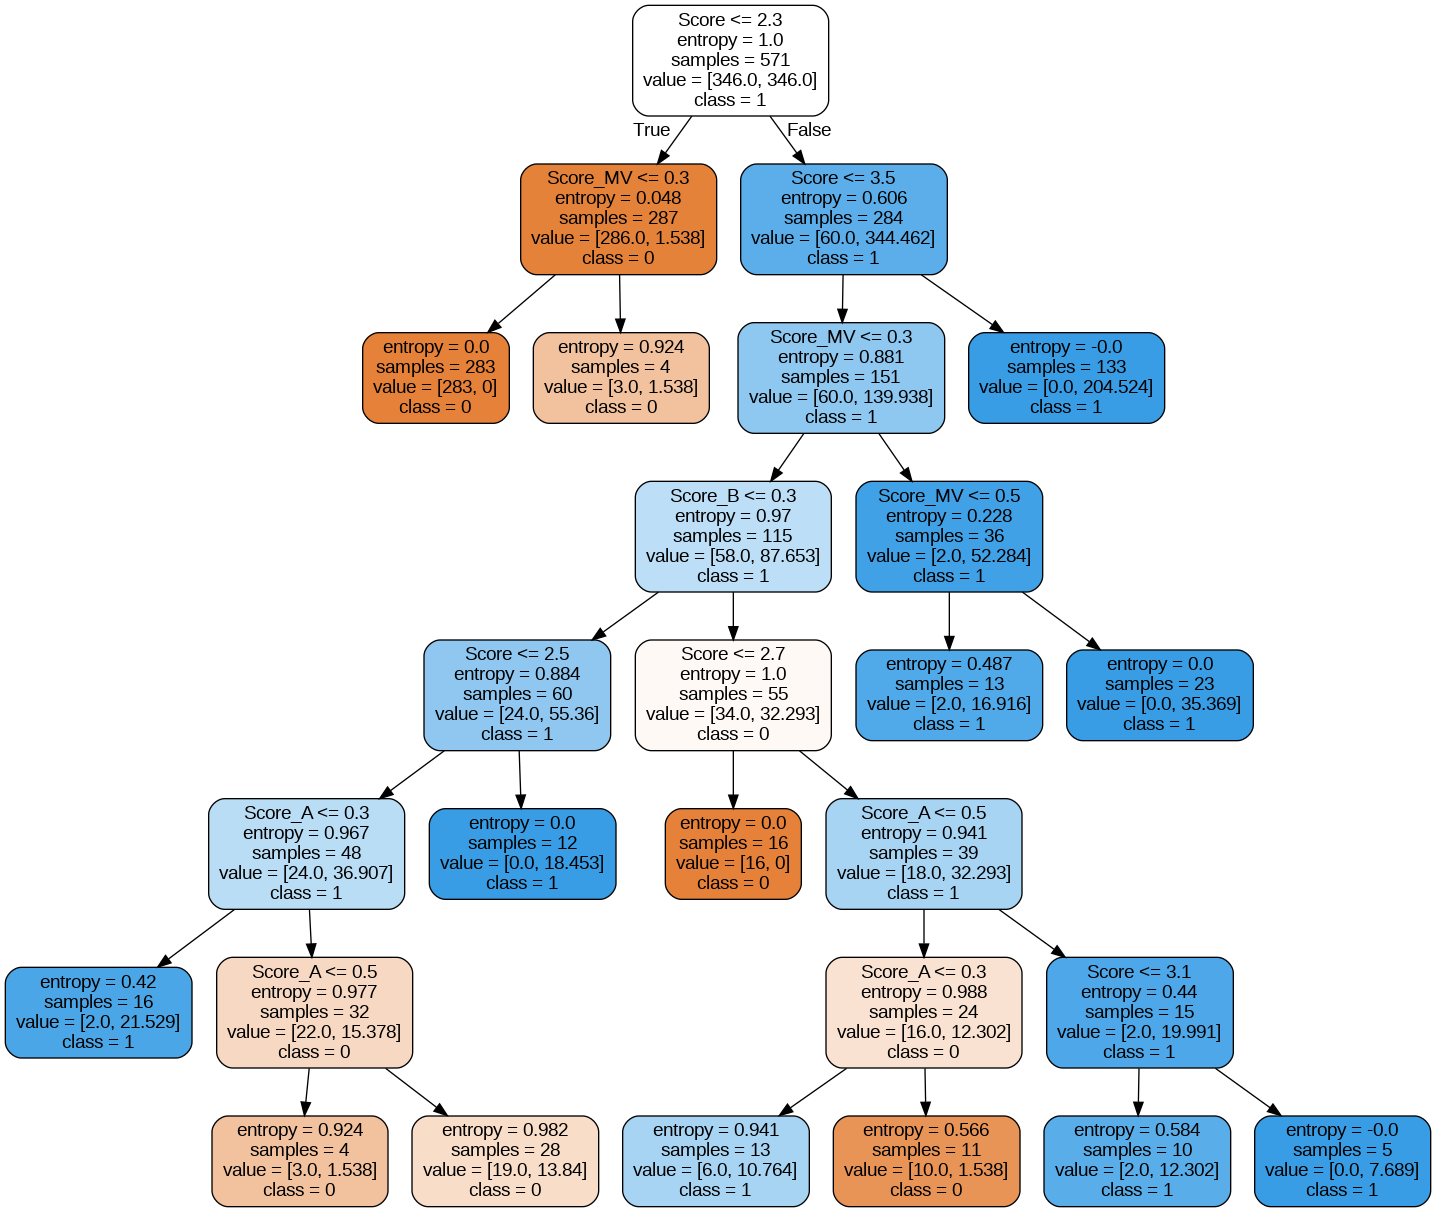

In [83]:
nombres_caract_originales = X_selected_df.columns

Mostrar_Arbol(modelo, nombres_caract_originales)

**Caracteristica escogida como nodo raíz**
El Score se escoge como nodo raíz debido a que existe una correlación alta entre esta característica y la característica objetivo.

#### **Matriz de confusión**

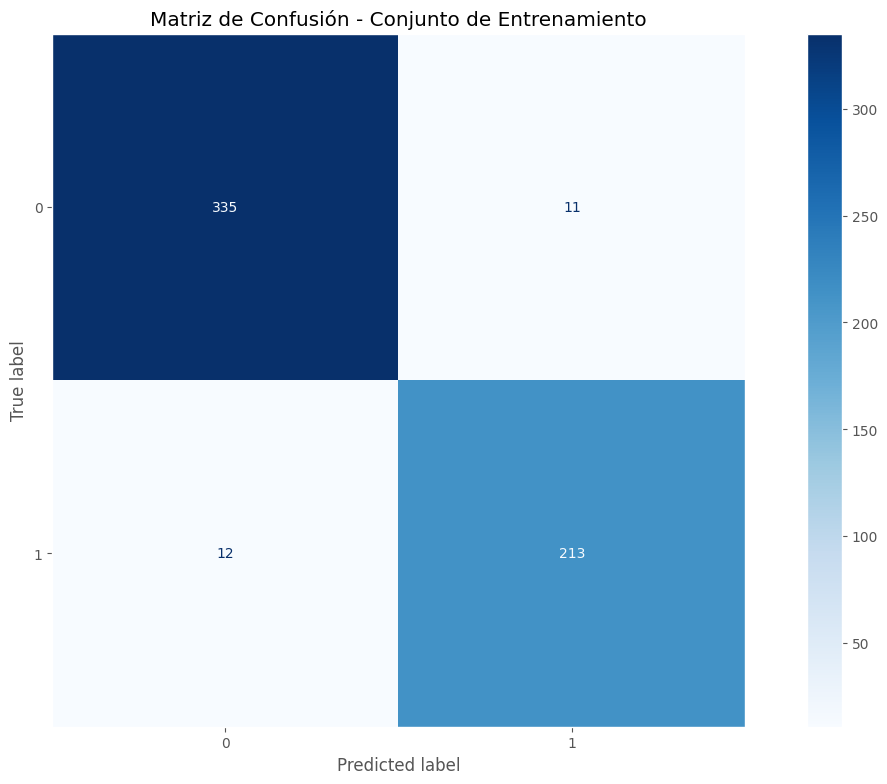

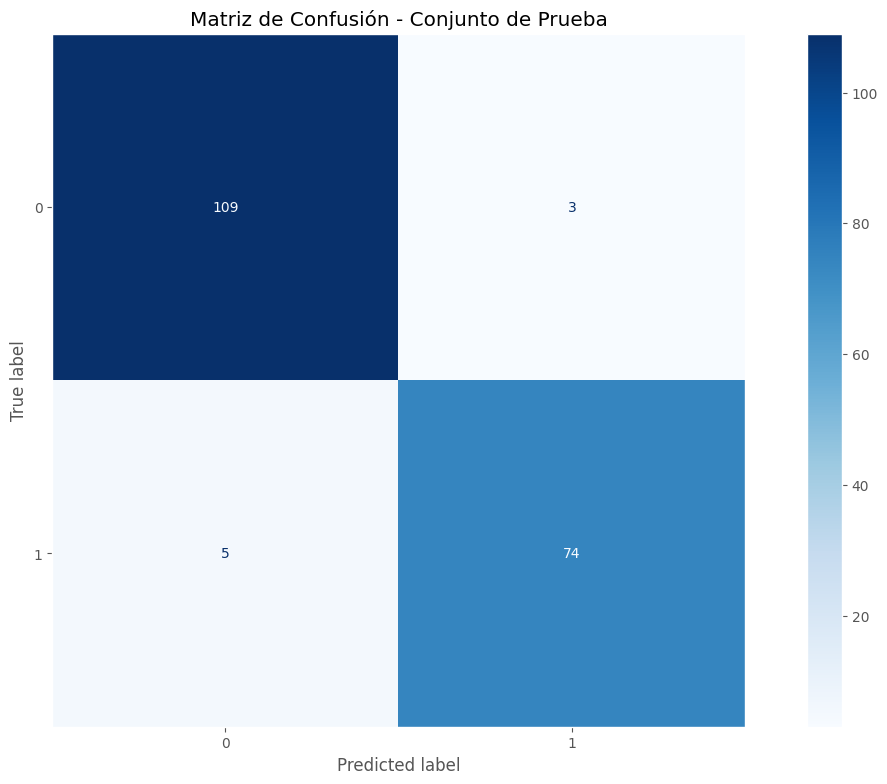

In [88]:
# Entrenamos el modelo con el conjunto de entrenamiento
model = DecisionTreeClassifier(class_weight=class_weight_dict)
model.fit(X_train, y_train)

# Predecimos con el conjunto de entrenamiento y prueba
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Generamos la matriz de confusión para el conjunto de entrenamiento
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=model.classes_)
disp_train.plot(cmap='Blues')
plt.title("Matriz de Confusión - Conjunto de Entrenamiento")
plt.grid(False)  # Quitar la cuadrícula
plt.show()

# Generamos la matriz de confusión para el conjunto de prueba
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=model.classes_)
disp_test.plot(cmap='Blues')
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.grid(False)  # Quitar la cuadrícula
plt.show()



La matriz de confusión de los datos de entrenamiento como los de prueba muestran que el modelo tiene un buen rendimiento, con altas tasas de precisión y sensibilidad. Esto sugiere que el modelo generaliza bien y no está sobreajustado al conjunto de entrenamiento.

- Datos de entrenamiento: para los datos de entrenamiento parece tener buen ajuste. Para los datos de clase 0 por ejemplo tiene 335 aciertos y 11 falsos positivos, y del tipo 1 tenemos 213 aciertos y 12 clasificados erroneamente.
- Datos de prueba: para la clase 0 tiene una precisión de (109 de 112) y para la clase 1 tiene una precisión de (74 de 79).

##Exactitud

In [85]:
print("Exactitud para el entrenamiento =", modelo.score(X_train, y_train))
print("Exactitud para prueba =", modelo.score(X_test, y_test))

Exactitud para el entrenamiento = 0.957968476357268
Exactitud para prueba = 0.9581151832460733


El modelo tiene una alta exactitud tanto en el conjunto de entrenamiento como en el de prueba, lo que indica que está clasificando correctamente aproximadamente el 96% de las muestras en ambos conjuntos. Esto sugiere que el modelo generaliza bien y no está sobreajustado a los datos de entrenamiento.

##Precisión

In [91]:
print("Metricas para datos de entrenamiento")
print(classification_report(y_train, modelo.predict(X_train)))

print("//////////////////////////////////////////////////////")

print("Metricas para datos de prueba")
print(classification_report(y_test, modelo.predict(X_test)))

Metricas para datos de entrenamiento
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       346
           1       0.95      0.95      0.95       225

    accuracy                           0.96       571
   macro avg       0.96      0.96      0.96       571
weighted avg       0.96      0.96      0.96       571

//////////////////////////////////////////////////////
Metricas para datos de prueba
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       112
           1       0.96      0.94      0.95        79

    accuracy                           0.96       191
   macro avg       0.96      0.95      0.96       191
weighted avg       0.96      0.96      0.96       191



El modelo tiene un rendimiento consistente y alto tanto en el conjunto de entrenamiento como en el de prueba, con una exactitud del 96%. Las métricas de precisión, recall y F1-score también son altas, indicando un buen equilibrio entre las clases y una buena capacidad de generalización.

## GNB

###**IMPLEMENTACIÓN** (Naive Bayes Gaussiano)

In [92]:
class NaiveBayes:

    def fit(self, X, y):
        n_instancias, n_caracteristicas = X.shape
        self._clases = np.unique(y)
        n_clases = len(self._clases)

        # Calculamos la media, la varianza y el prior para cada clase
        self._media = np.zeros((n_clases, n_caracteristicas), dtype=np.float64)
        self._varianza = np.zeros((n_clases, n_caracteristicas), dtype=np.float64)
        self._priors = np.zeros(n_clases, dtype=np.float64)

        # Llenamos los arreglos
        for i, c in enumerate(self._clases):
            X_c = X[y == c]  # Seleccionamos la clase que necesitemos
            self._media[i, :] = X_c.mean(axis=0)  # Media para cada característica
            self._varianza[i, :] = X_c.var(axis=0)  # Varianza para cada característica
            self._priors[i] = X_c.shape[0] / float(n_instancias)  # Prior de la clase

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]  # List comprehension con las predicciones
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        # Calculamos el posterior para cada clase
        for i, c in enumerate(self._clases):
            prior2 = np.log(self._priors[i])
            posterior = np.sum(np.log(self._pdf(i, x)))
            posterior = posterior + prior2
            posteriors.append(posterior)

        # Retornamos la clase con el posterior máximo
        return self._clases[np.argmax(posteriors)]

    def _pdf(self, clase_i, x):
        media = self._media[clase_i]
        varianza = self._varianza[clase_i]

        # Añadimos un pequeño valor para evitar división por cero
        varianza[varianza == 0] += 1e-9

        numerador = np.exp(-((x - media) ** 2) / (2 * varianza))
        denominador = np.sqrt(2 * np.pi * varianza)
        return numerador / denominador


Ahora veamos qué tal funciona nuestra implementación con una métrica de exactitud "accuracy":

In [99]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

nb = NaiveBayes()
X_train, X_test, y_train, y_test = train_test_split(X_selected_array, y_clean, random_state = 1)
nb.fit(X_train, y_train)
predicciones = nb.predict(X_test)

print(accuracy(y_test, predicciones))

0.9057591623036649


Repliquemos el experimento con el algoritmo de Naive Bayes Gaussiano de Scikit-learn:

In [94]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
accuracy(y_test, y_pred)

0.9057591623036649

## Métricas

In [106]:
from sklearn.metrics import accuracy_score

# Calculamos la exactitud para los datos de entrenamiento
train_accuracy = accuracy_score(y_train, gnb.predict(X_train))
print("Exactitud para el entrenamiento:", train_accuracy)

# Calculamos la exactitud para los datos de prueba
test_accuracy = accuracy_score(y_test, gnb.predict(X_test))
print("Exactitud para prueba:", test_accuracy)


Exactitud para el entrenamiento: 0.8879159369527145
Exactitud para prueba: 0.9057591623036649


## Justificación

### Comparación de Resultados entre Naive Bayes (GNB) y Árbol de Decisión (DT)

#### Naive Bayes (GNB):
- **Exactitud para el Entrenamiento**: 0.888
- **Exactitud para Prueba**: 0.906

#### Árbol de Decisión (DT):
- **Exactitud para el Entrenamiento**: 0.958
- **Exactitud para Prueba**: 0.958

### Interpretación:

1. **Exactitud para el Entrenamiento**:
   - **GNB**: 88.8%
   - **DT**: 95.8%
   - **Comparación**: El modelo de Árbol de Decisión tiene una exactitud significativamente mayor en el conjunto de entrenamiento, lo que indica que clasifica correctamente una mayor proporción de muestras en comparación con el modelo de Naive Bayes.

2. **Exactitud para Prueba**:
   - **GNB**: 90.6%
   - **DT**: 95.8%
   - **Comparación**: El modelo de Árbol de Decisión también supera al modelo de Naive Bayes en el conjunto de prueba, mostrando una mejor capacidad de generalización a datos no vistos.

### Conclusión:
El modelo de Árbol de Decisión (DT) muestra una mejor exactitud tanto en el conjunto de entrenamiento como en el de prueba en comparación con el modelo de Naive Bayes (GNB). Esto sugiere que el DT es más efectivo para este conjunto de datos, proporcionando predicciones más precisas y consistentes.